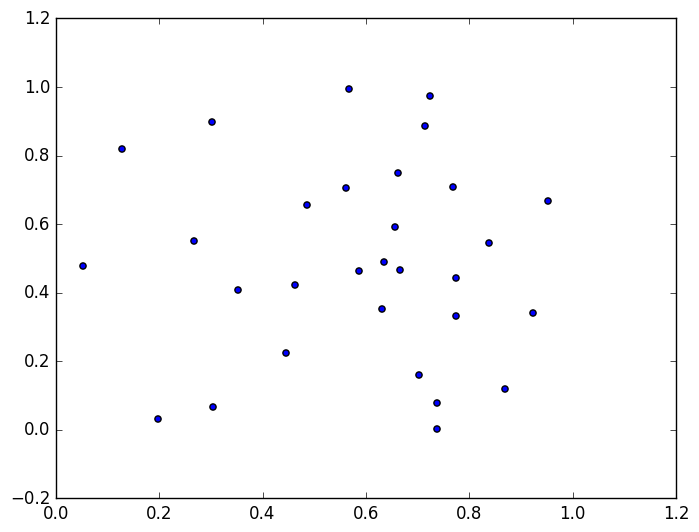

PyObject <matplotlib.collections.PathCollection object at 0x31863d450>

In [23]:
using PyPlot
points = rand(30,2)
scatter(points[:,1],points[:,2])

## Compute side lengths for all possible triangles from points

In [19]:
function compute_side_lengths(points)
    sidesarr = [0,0,0]
    for i = collect(1:size(points)[1])
        for j = collect(1:size(points)[1])
            for k = collect(1:size(points)[1])
                d1 = hypot(abs(points[i,1]-points[j,1]),abs(points[i,2]-points[j,2]))
                d2 = hypot(abs(points[k,1]-points[j,1]),abs(points[k,2]-points[j,2]))
                d3 = hypot(abs(points[i,1]-points[k,1]),abs(points[i,2]-points[k,2]))
                sidesarr = hcat(sidesarr,[d1,d2,d3])
            end
        end
    end

    goodtriangles = [0,0,0]
    for i in [1:size(sidesarr)[2]]
        if !(0 in sidesarr[:,i])
            goodtriangles = hcat(goodtriangles,sidesarr[:,i])
        end
    end
    goodtriangles = goodtriangles[:,2:end]
    return goodtriangles
end

compute_side_lengths (generic function with 1 method)

## Implement treecorr and ntropy selections
* need to have v requirements symmetric in treecorr for homebrew and package to agree

In [67]:
maxr = .6
minr = .5
maxu = 1.0
minu = .95
maxv = .05
minv = -.05

function filterTriangles(goodtriangles,binning="treecorr")
    mytriangles = [0,0,0]
    for i in collect(1:size(goodtriangles)[2])
        thistri = goodtriangles[:,i]
        sorted = sort(thistri,rev=true)
        r = sorted[2]
        u = sorted[3]/sorted[2]
        v = (sorted[1]-sorted[2])/sorted[3]
        if (binning == "treecorr")
            if (minr < r <maxr) & (minu < u < maxu) & (minv < v < maxv)
                #print(r," ",u," ",v,"\n")
                mytriangles = hcat(mytriangles,thistri)
            end
        end
        if binning == "ntropy"
            #if all((thistri .> minu*minr) & (thistri .< (1+maxv)*maxr))
            if all((thistri .> minr) & (thistri .< maxr))
                #print(r," ",u," ",v,"\n")
                mytriangles = hcat(mytriangles,thistri)
            end
        end
    end
    mytriangles = mytriangles[:,2:end]
    return mytriangles
end

filterTriangles (generic function with 2 methods)

## Run unit tests

In [5]:
using PyCall
@pyimport treecorr

In [70]:
#compute treecorr prediction
nnn = treecorr.NNNCorrelation(min_sep=minr, max_sep=maxr, nbins=1, min_u=minu,
max_u=maxu, nubins=1, min_v=minv, max_v=maxv, nvbins=1, bin_slop=0, sep_units="arcmin")
cat = treecorr.Catalog(ra=points[:,1],dec=points[:,2],ra_units="arcmin",dec_units="arcmin")
nnn[:process](cat)

In [71]:
goodtriangles = compute_side_lengths(points)
print("treecorr homebrew finds ",size(filterTriangles(goodtriangles,"treecorr"))[2]/6," unique triangles \n")
print("treecorr package finds ",nnn[:ntri][1]," unique triangles \n")
print("ntropy homebrew finds ",size(filterTriangles(goodtriangles,"ntropy"))[2]/6," unique triangles")
#/3 for array size; /2 for sides counted both ways; /3 for 3 ways to list sides

treecorr homebrew finds 3.0 unique triangles 
treecorr package finds 3.0 unique triangles 
ntropy homebrew finds 11.0 unique triangles

In [72]:
filterTriangles(goodtriangles,"treecorr")

3x18 Array{Float64,2}:
 0.558013  0.558071  0.599149  0.583322  …  0.575095  0.583322  0.575095
 0.551504  0.551504  0.575095  0.575095     0.583322  0.599149  0.599149
 0.558071  0.558013  0.583322  0.599149     0.599149  0.575095  0.583322

In [73]:
filterTriangles(goodtriangles,"ntropy")

3x66 Array{Float64,2}:
 0.558013  0.590089  0.558071  0.599149  …  0.547172  0.547172  0.518871
 0.551504  0.518871  0.551504  0.575095     0.555495  0.502512  0.590089
 0.558071  0.525954  0.558013  0.583322     0.507955  0.578775  0.525954

In [74]:
points

30x2 Array{Float64,2}:
 0.713741   0.886015  
 0.304132   0.0653257 
 0.301147   0.897247  
 0.737548   0.00251729
 0.870041   0.119599  
 0.267677   0.550747  
 0.634757   0.489154  
 0.0533535  0.478276  
 0.198476   0.0305811 
 0.567929   0.992821  
 0.952182   0.668988  
 0.702642   0.15983   
 0.630723   0.352156  
 ⋮                    
 0.662211   0.750079  
 0.56224    0.704256  
 0.445792   0.223329  
 0.773685   0.441702  
 0.352726   0.407844  
 0.586378   0.463758  
 0.92403    0.341916  
 0.72449    0.972795  
 0.656467   0.59027   
 0.463111   0.423617  
 0.665966   0.465724  
 0.736611   0.0787775 

In [ ]:
outfile = open("./mike_test.txt", "w")
write(outfile,points,"\n")
close(outfile)